# Imports

In [1]:
import warnings
import pandas as pd

from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from dstoolkit.automl import AutoMLClustering, AutoMLPCA

/home/junior/Documentos/GitHub/data-science-toolkit/venv/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
warnings.filterwarnings("ignore")

## Functions

In [3]:
def generate_synthetic_clustering_data(
    n_samples=2000,
    n_features=10,
    n_clusters=5,
    cluster_std=1.0,
    test_size=0.2,
    valid_size=0.2,
    random_state=42
):
    """
    Gera dados sintéticos para problemas de clusterização (agrupamento não supervisionado).
    
    Parâmetros
    ----------
    n_samples : int
        Número total de observações a serem geradas.
    n_features : int
        Número total de variáveis (dimensionalidade).
    n_clusters : int
        Número de clusters a serem simulados.
    cluster_std : float
        Desvio-padrão dos clusters (quanto maior, mais sobreposição entre eles).
    test_size : float
        Proporção da base reservada para teste.
    valid_size : float
        Proporção da base de treino reservada para validação.
    random_state : int
        Semente para reprodutibilidade.
    
    Retorna
    -------
    X_train, X_valid, X_test, y_train, y_valid, y_test : pd.DataFrame
        Bases de treino, validação e teste, com os rótulos verdadeiros dos clusters 
        (úteis apenas para avaliação, não para treinamento real de clustering).
    """

    X, y = make_blobs(
        n_samples=n_samples,
        n_features=n_features,
        centers=n_clusters,
        cluster_std=cluster_std,
        random_state=random_state
    )

    # Cria DataFrames nomeados
    feature_names = [f"feature_{i}" for i in range(n_features)]
    X = pd.DataFrame(X, columns=feature_names)
    y = pd.DataFrame(y, columns=["cluster_label"])

    # Divide em treino/teste
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Divide parte de treino em treino/validação
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train, y_train, test_size=valid_size, random_state=random_state, stratify=y_train
    )

    return X_train, y_train, X_valid, y_valid, X_test, y_test

## Data Base

In [4]:
X, _, _, _, _, _ = generate_synthetic_clustering_data()

# Feature Engineering

In [5]:
ss = StandardScaler()
X_scaled = ss.fit_transform(X)

# Modeling

## PCA

In [6]:
pca = AutoMLPCA(scoring='reconstruction_error', n_trials=20)
pca.train(X_scaled)
pca.get_metrics()

Explained Variance  Reconstruction Error  Trustworthiness
Train            0.997929             -0.002071         0.981926

In [7]:
X_pca = pca.model.transform(X_scaled)

## KMeans

In [8]:
kmeans = AutoMLClustering(model_name='KMeans')
kmeans.train(X_scaled)

In [9]:
kmeans.get_metrics()

Silhouette  Calinski Harabasz  Davies-Bouldin
Train    0.708562        4258.646309        0.425999

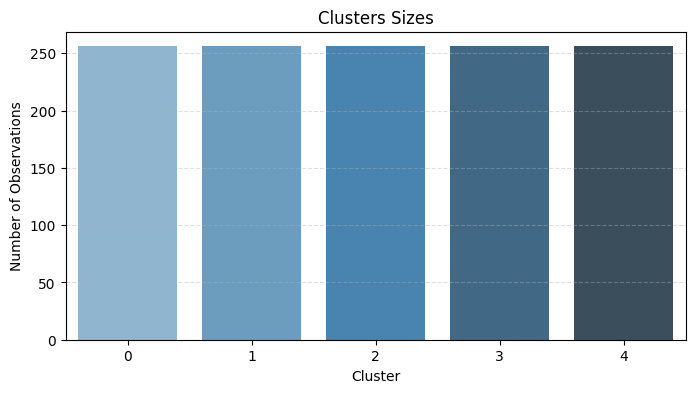

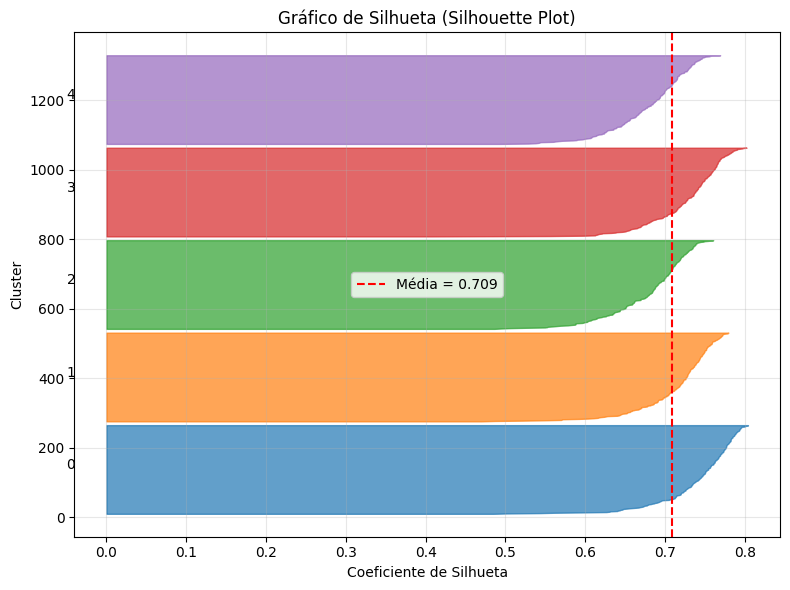

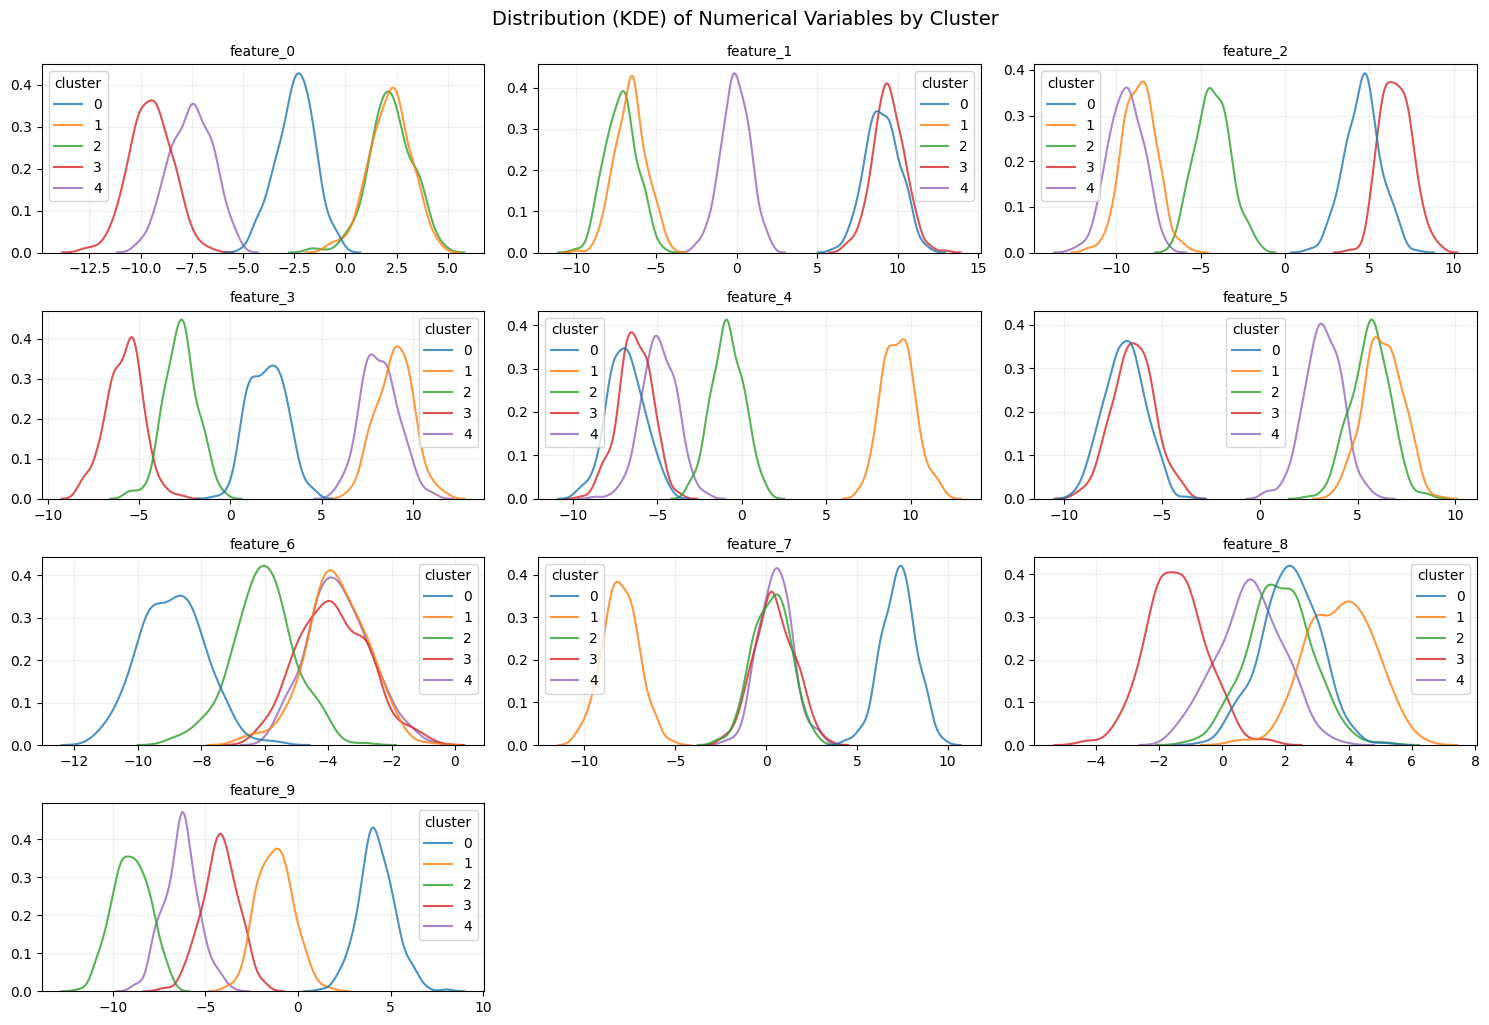

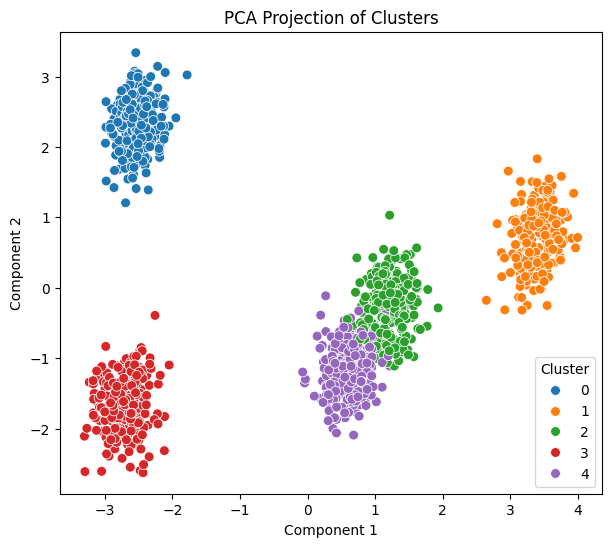

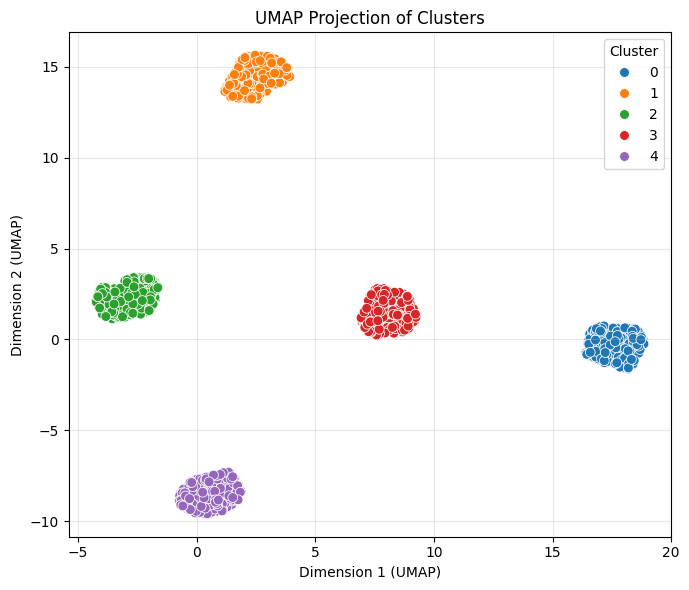

In [10]:
kmeans.analyze(X)

## KMeans + PCA

In [11]:
kmeans = AutoMLClustering(model_name='KMeans')
kmeans.train(X_pca)

In [12]:
kmeans.get_metrics()

Silhouette  Calinski Harabasz  Davies-Bouldin
Train    0.295717         242.123312        1.398316

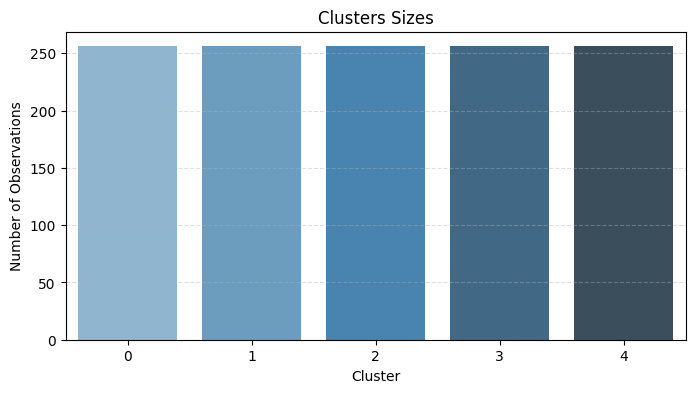

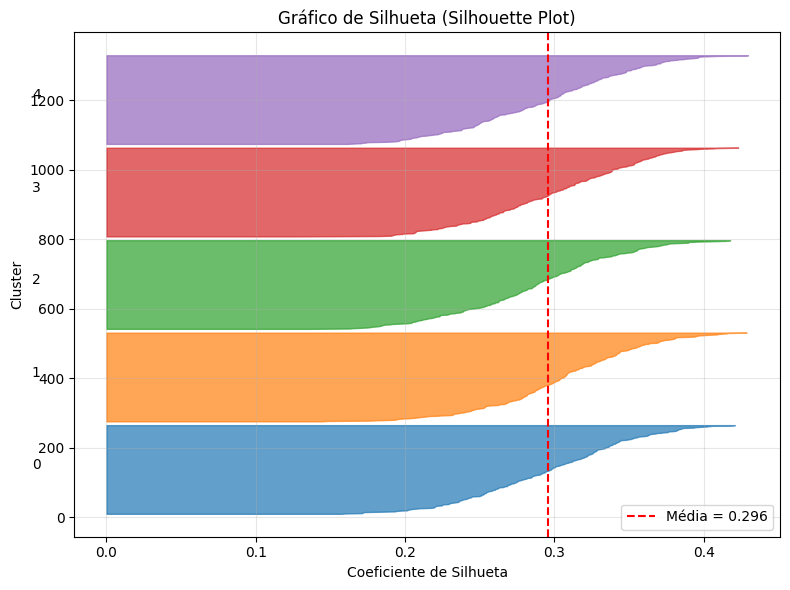

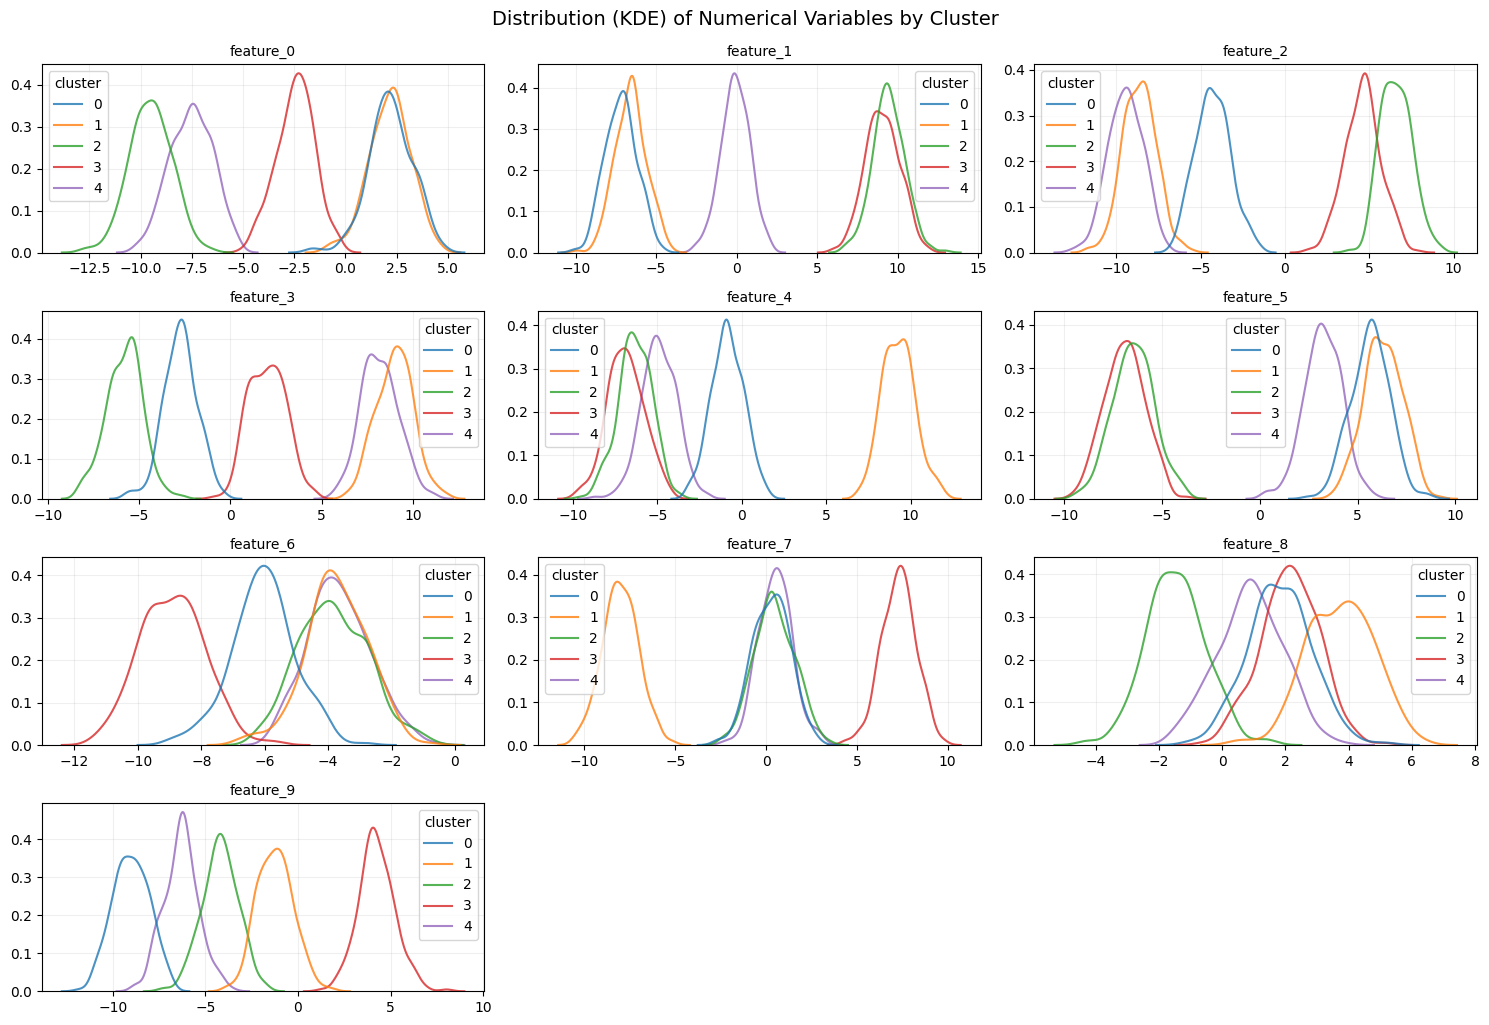

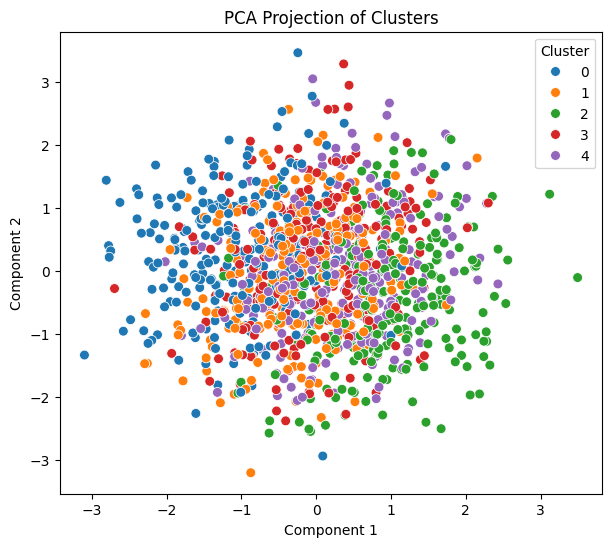

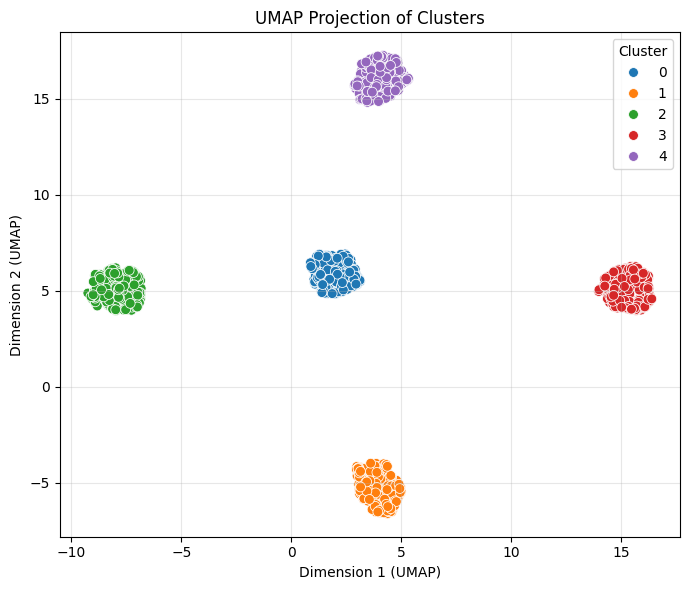

In [13]:
kmeans.analyze(X)

## GaussianMixture

In [14]:
gaussian = AutoMLClustering(model_name='GaussianMixture')
gaussian.train(X_scaled)

In [15]:
gaussian.get_metrics()

Silhouette  Calinski Harabasz  Davies-Bouldin
Train    0.708562        4258.646309        0.425999

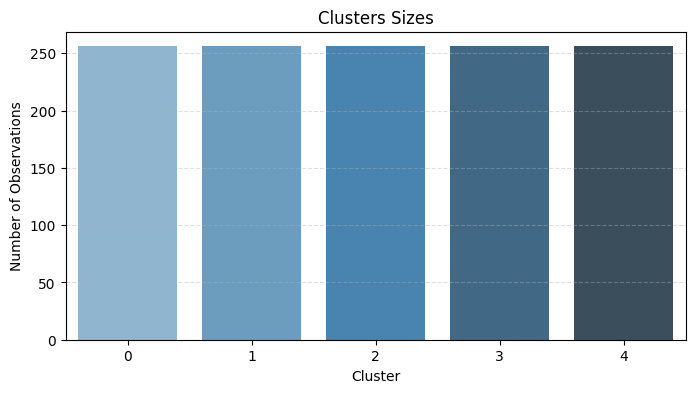

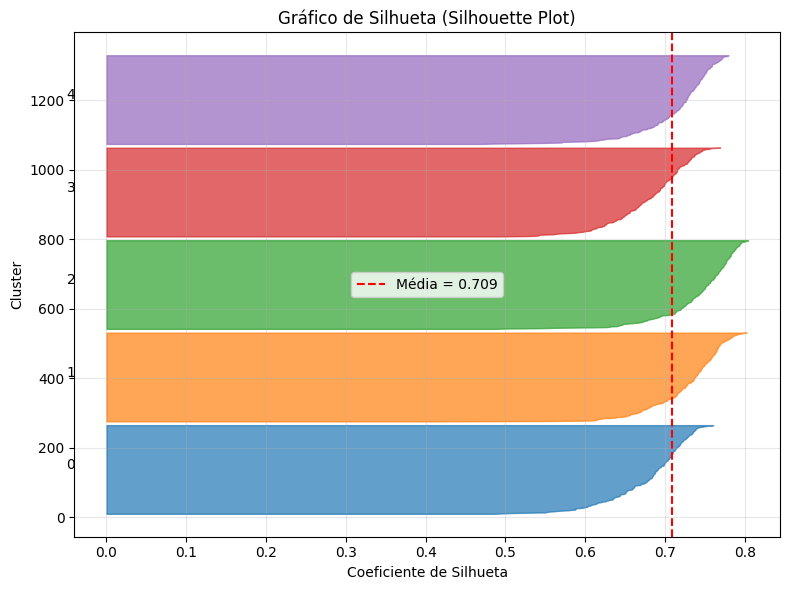

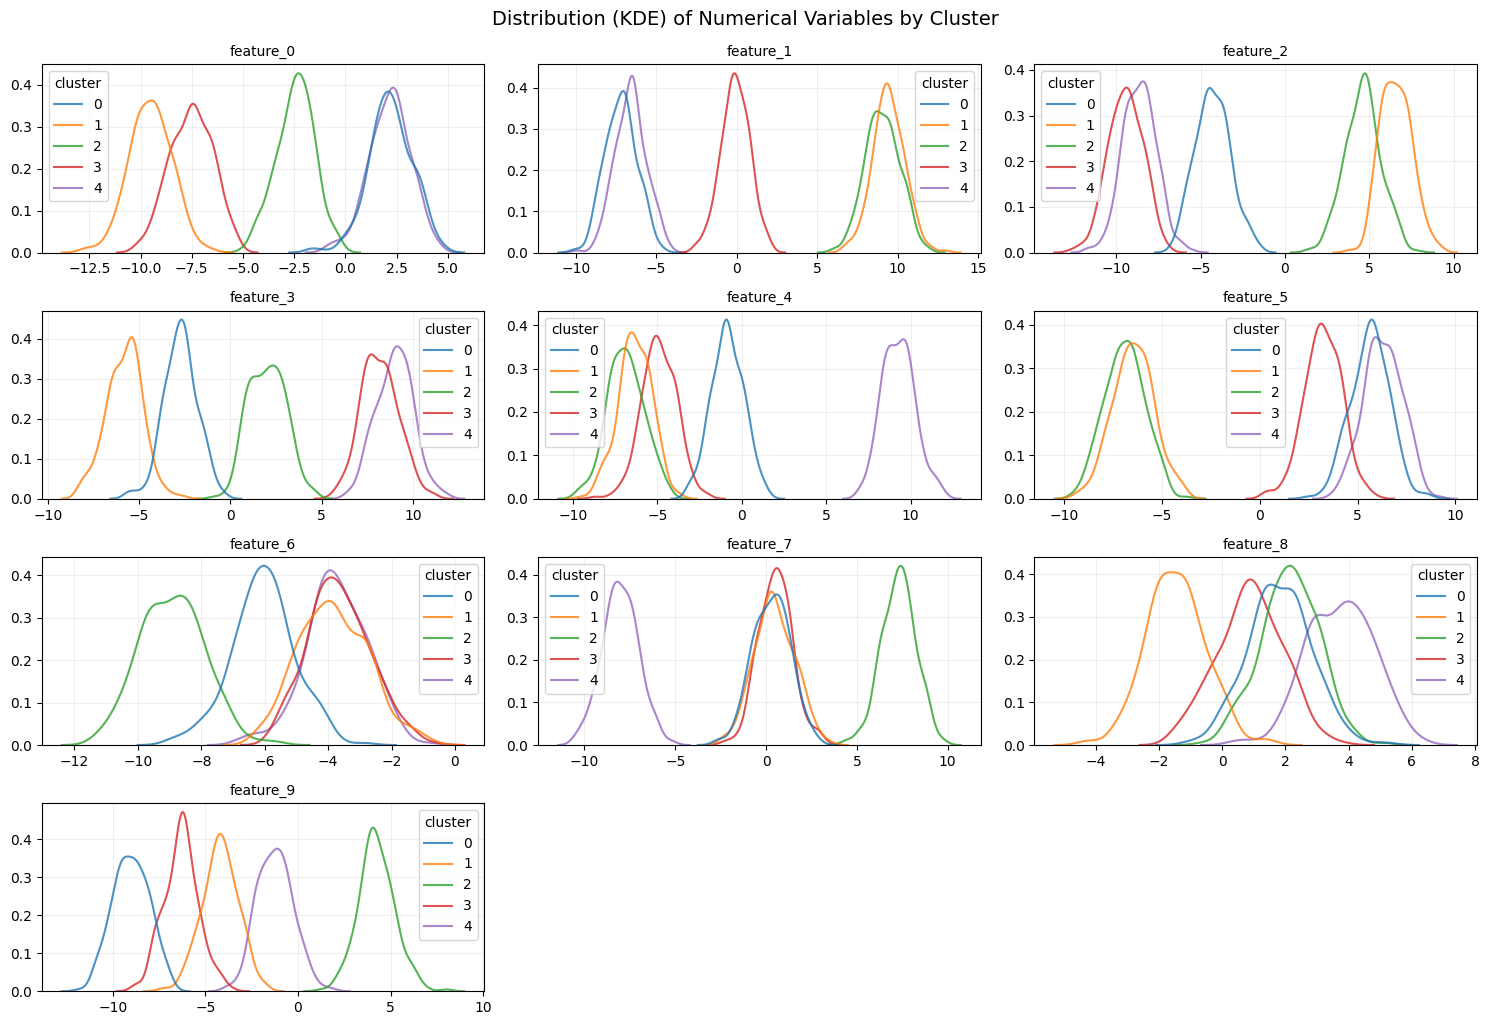

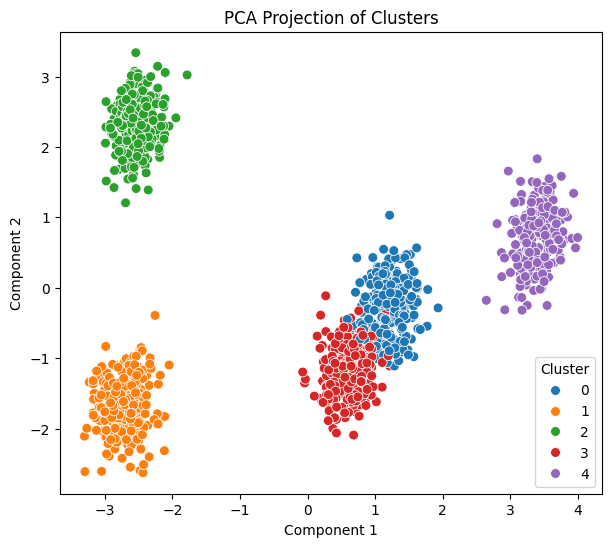

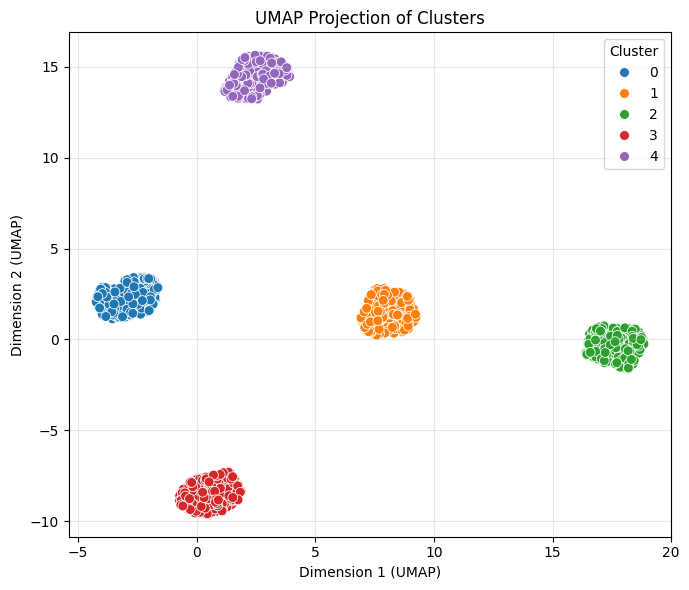

In [16]:
gaussian.analyze(X)

## MiniBatchKMeans

In [17]:
mini = AutoMLClustering(model_name='MiniBatchKMeans', n_trials=100, scoring='calinski')
mini.train(X_scaled)

In [18]:
mini.get_metrics()

Silhouette  Calinski Harabasz  Davies-Bouldin
Train    0.708562        4258.646309        0.425999

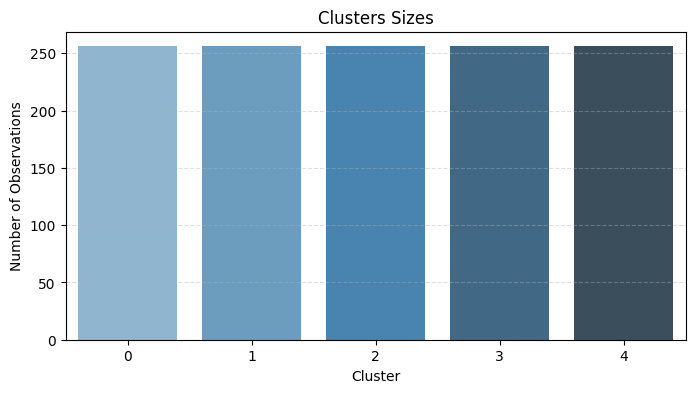

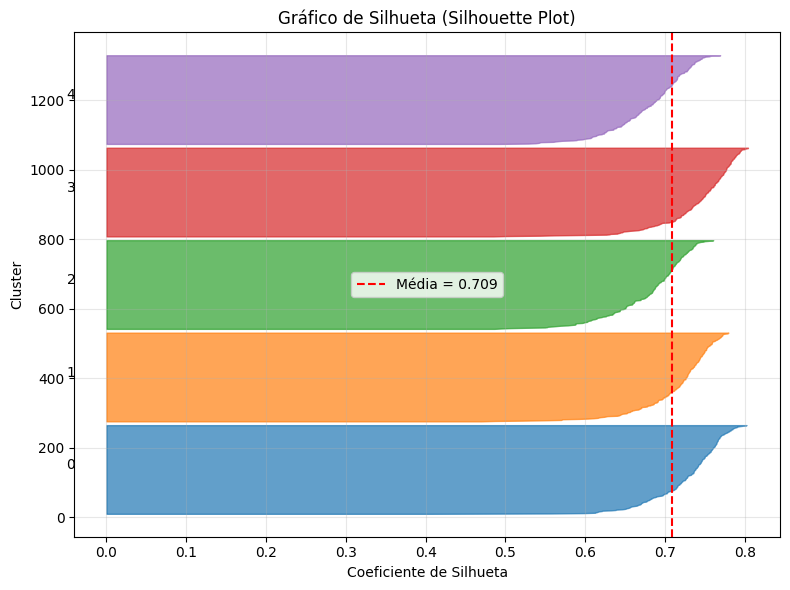

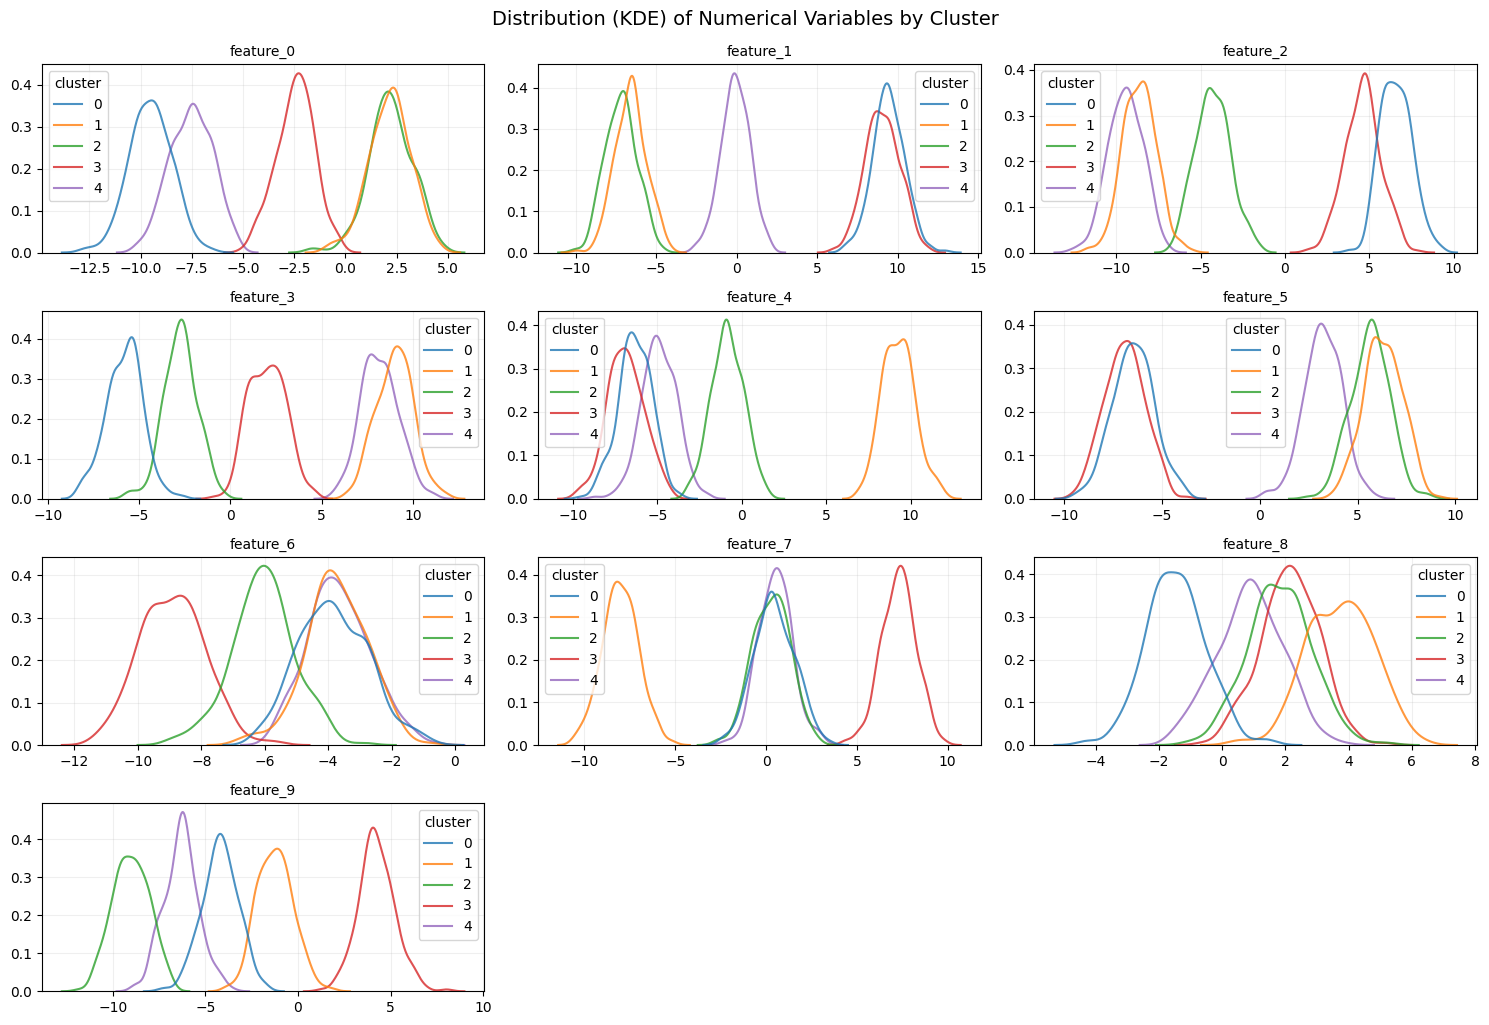

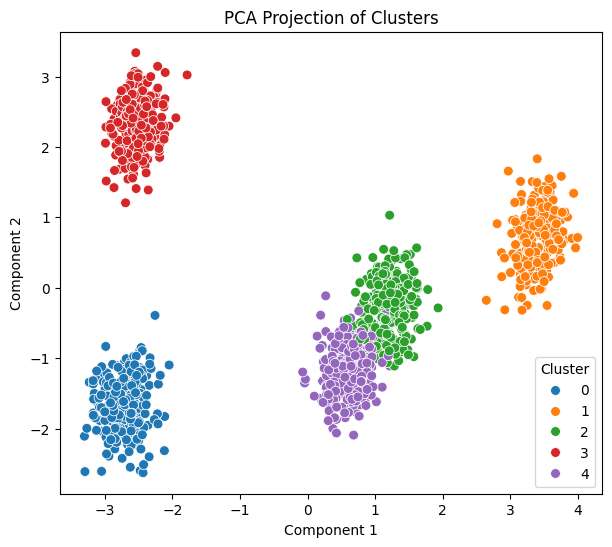

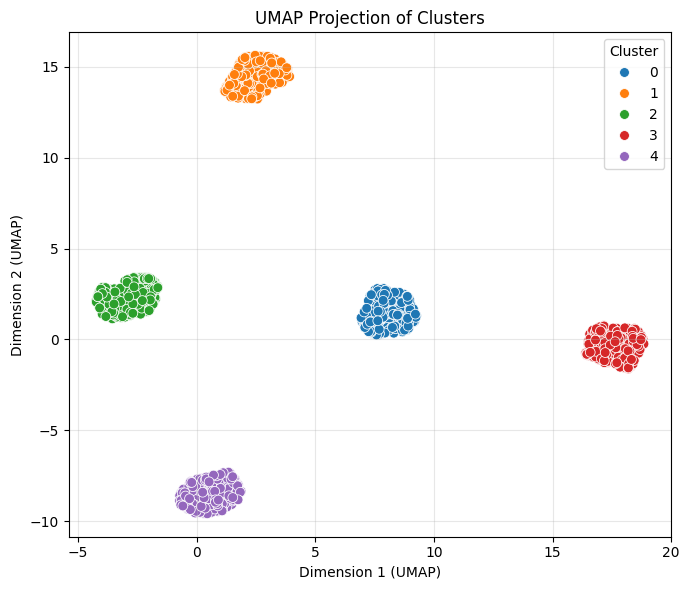

In [19]:
mini.analyze(X)

## Birch

In [20]:
birch = AutoMLClustering(model_name='Birch', n_trials=100, scoring='davies')
birch.train(X_pca)

In [21]:
birch.get_metrics()

Silhouette  Calinski Harabasz  Davies-Bouldin
Train    0.295717         242.123312        1.398316

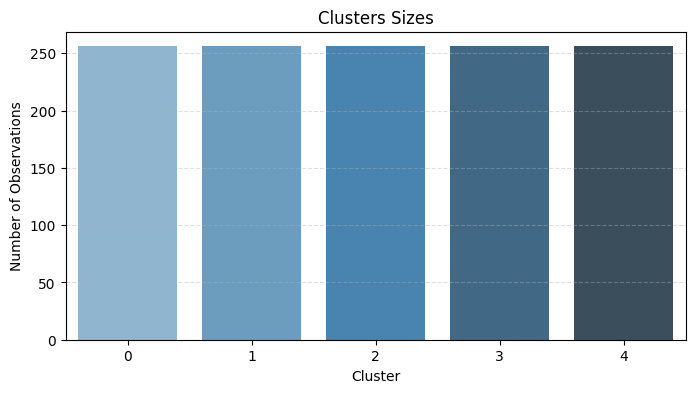

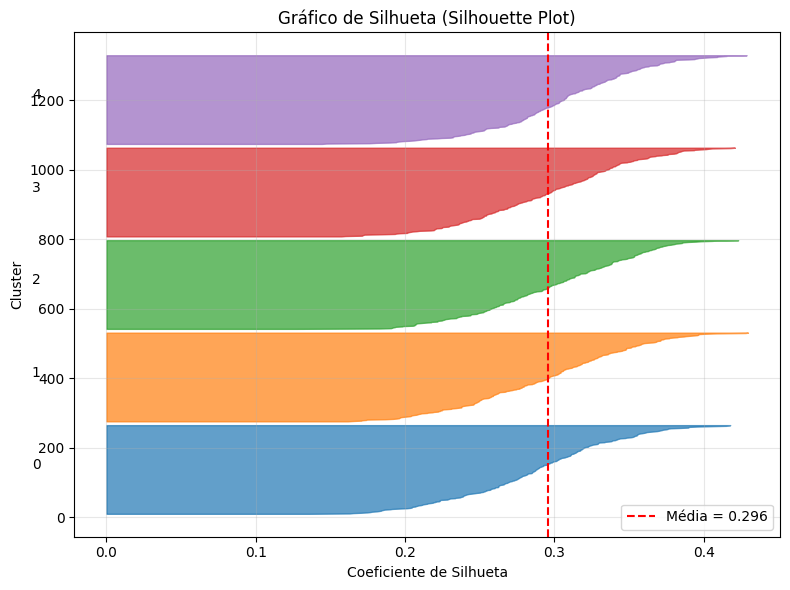

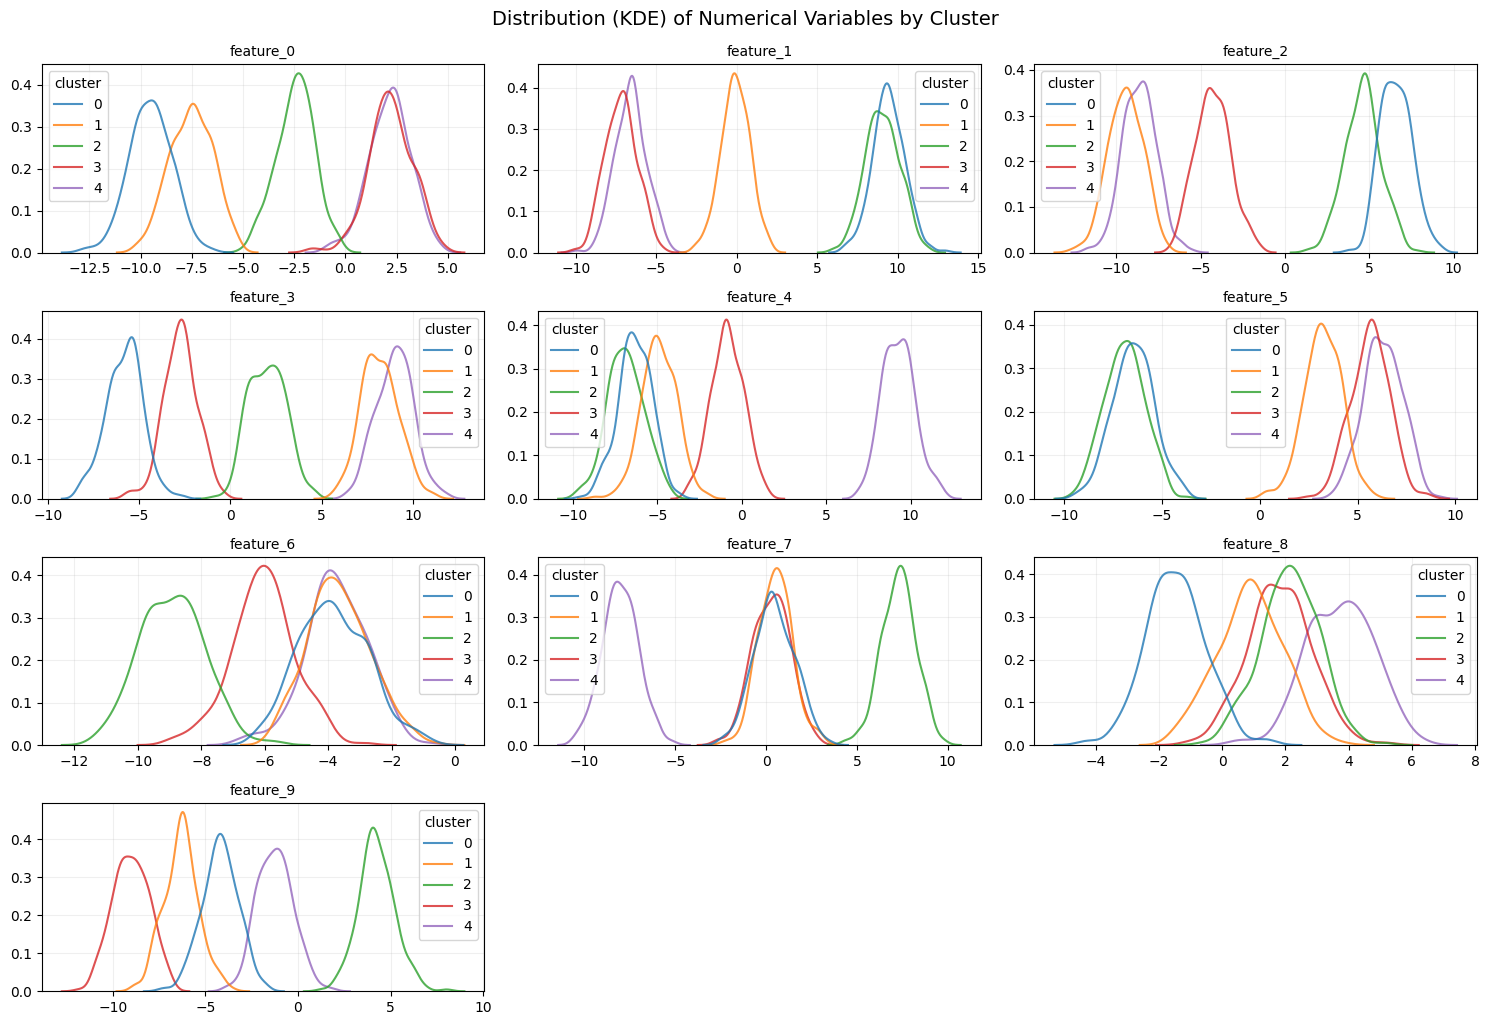

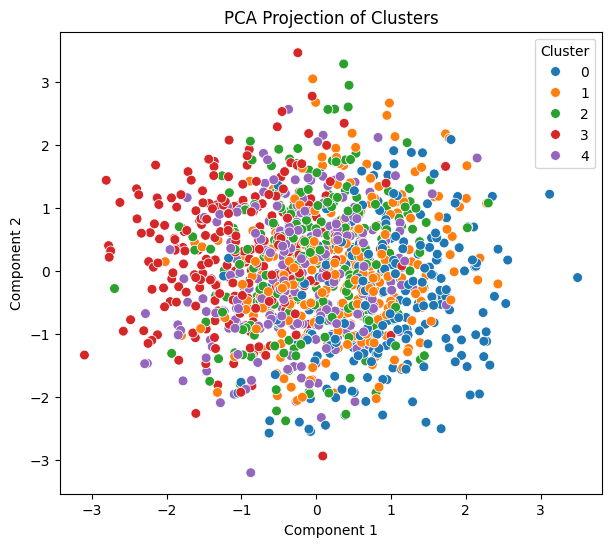

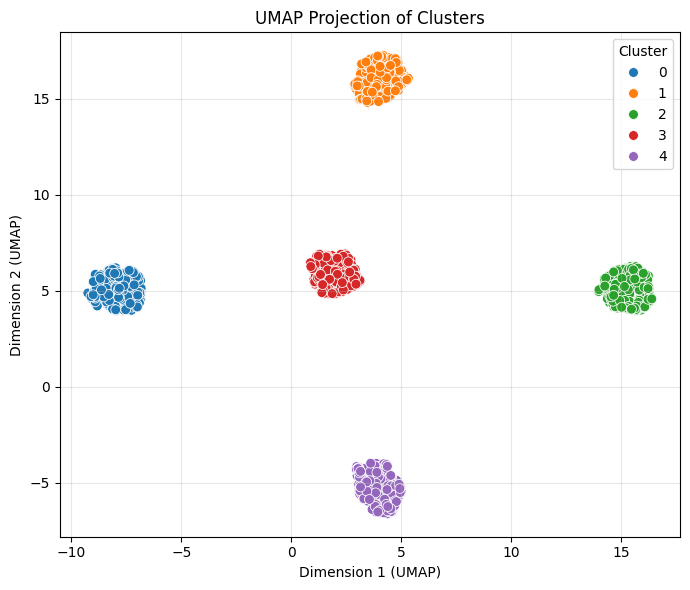

In [22]:
birch.analyze(X)

## BayesianGaussianMixture

In [23]:
bgm = AutoMLClustering(model_name='BayesianGaussianMixture', n_trials=100, scoring='silhouette')
bgm.train(X_scaled)

In [24]:
bgm.get_metrics()

Silhouette  Calinski Harabasz  Davies-Bouldin
Train    0.708562        4258.646309        0.425999

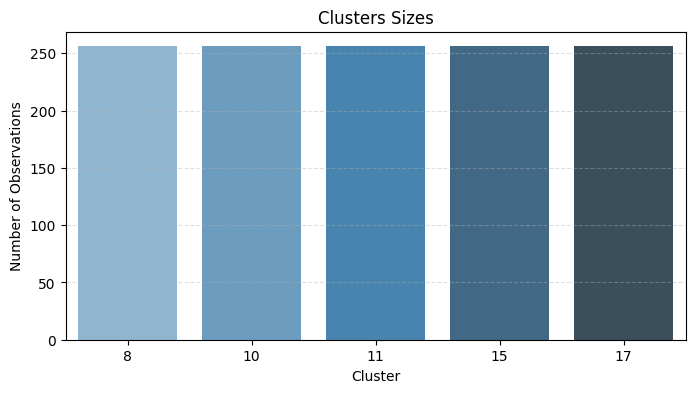

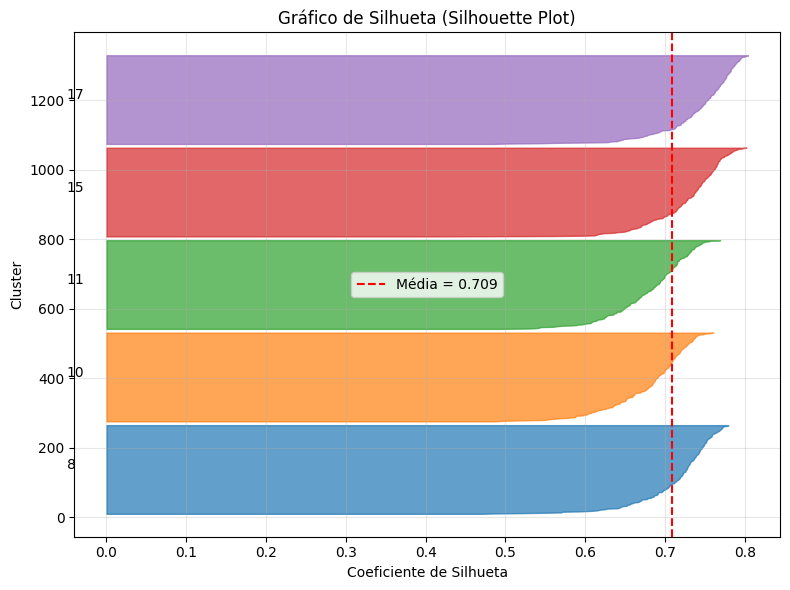

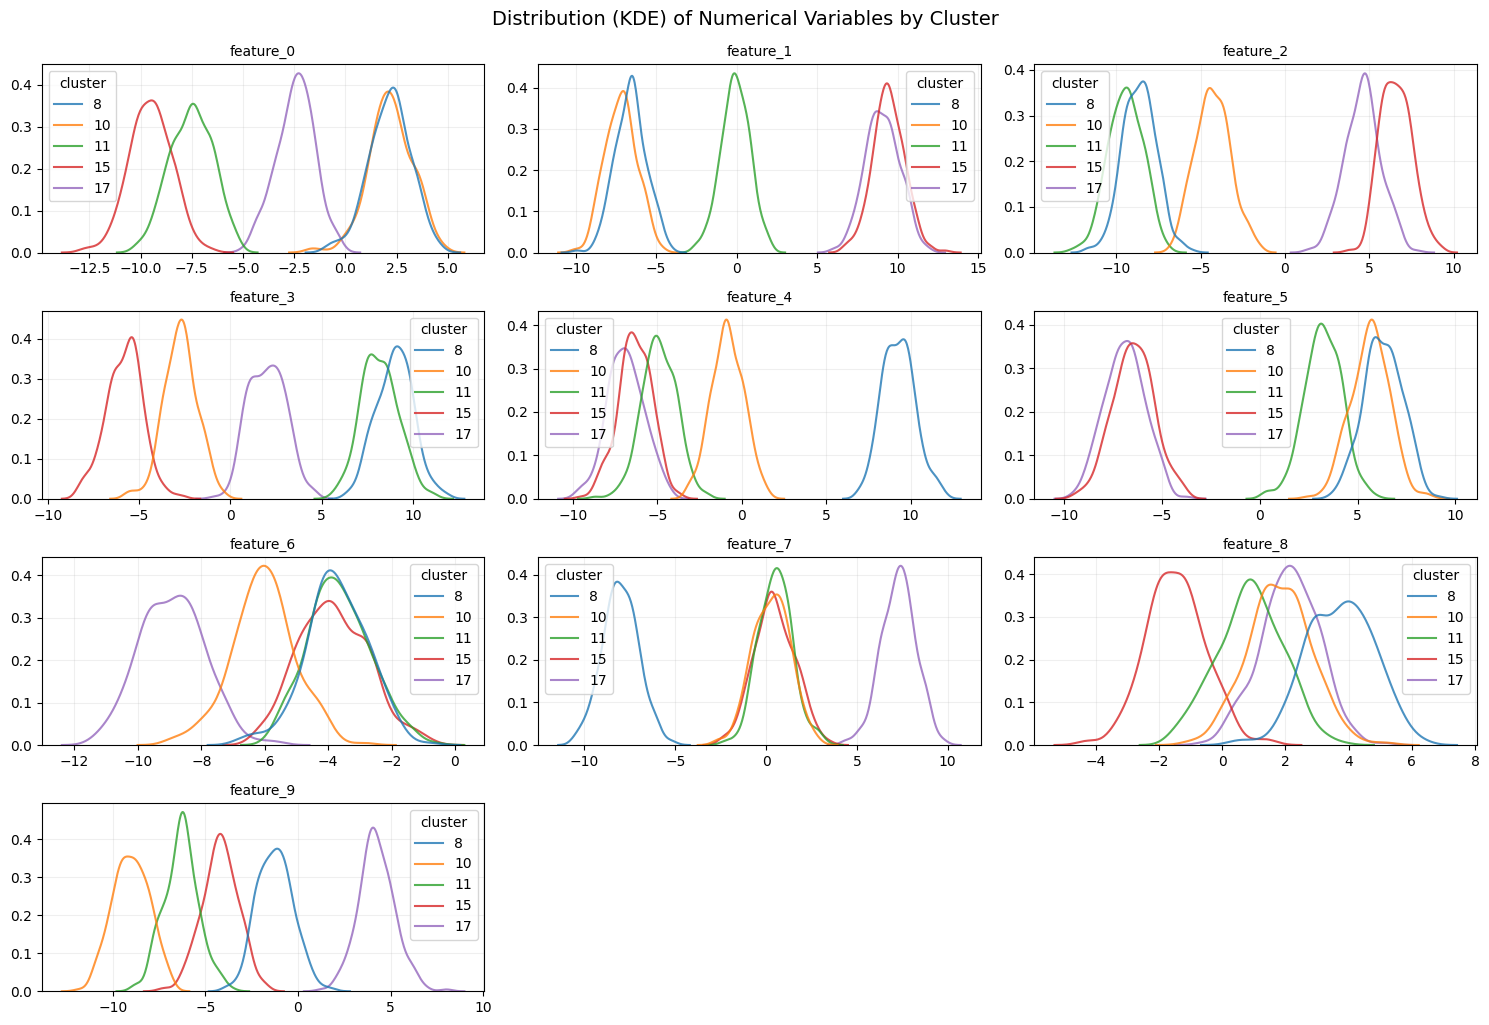

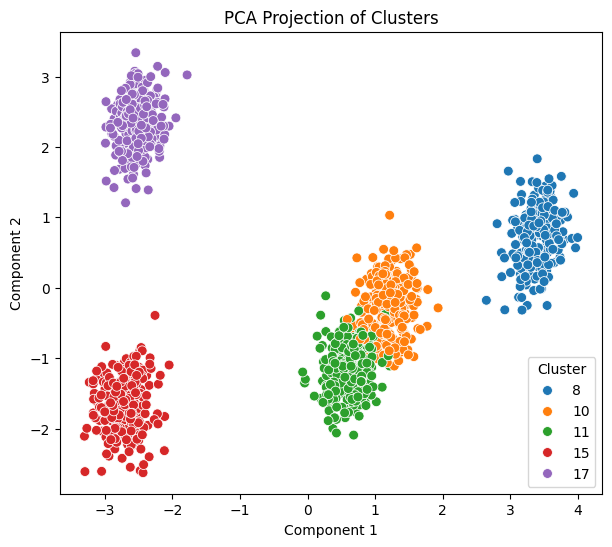

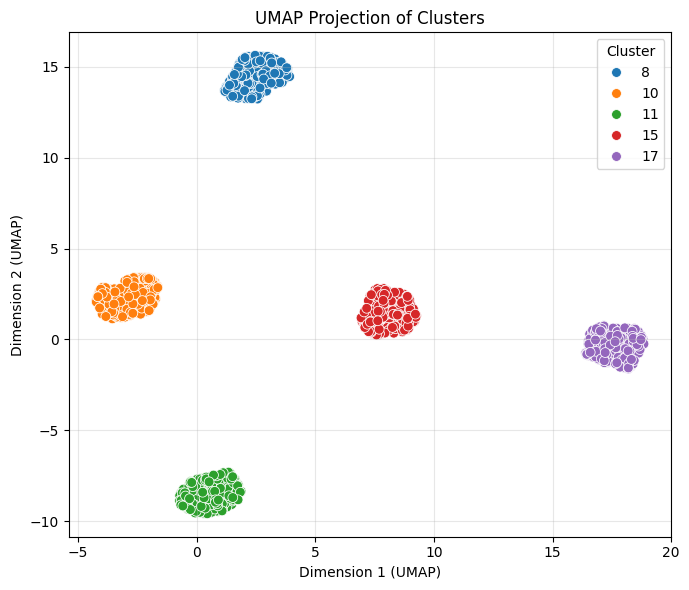

In [25]:
bgm.analyze(X)